In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from IPython.display import Latex, display, Markdown
import entsoapi
from entsoe import EntsoePandasClient
client = EntsoePandasClient(api_key=entsoapi.mykey)

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

> Saját adatok alapján, lehet energetikai, de más jellegű is, a lényeg a **kapcsolatvizsgálat számszerűsítése és értelmezése**. Adatgyűjtés, probléma pontos megfogalmazása, megfelelő **modell illesztése**, eredmények értelmezése kb 3-5 oldal + adatok.

Beadás április 30ig

# Leíró statisztika részvényadaton

Ebben a fejezetben -ismétlésképpen -  az egyszerű leíró statisztikai számokat vizsgálom az OTP  számomra elérhető 2002-2021 közti napi OHLC adatsorán.
Az adatok forrása a yahoo Finance. A _yfinance_ python könyvtáron keresztül töltöm le az adatokat pandas dataframe-be. A nyers adatokat nem tárolom fájl szinten, memoriából dolgozom fel.

## Adatgyűjtés

In [2]:
otp = yf.Ticker("OTP.BD")
otp_hist = otp.history(period="max", auto_adjust = True)

In [5]:
otp_hist.iloc[:,:5].head()

,Open,High,Low,Close,Volume
Date,,,,,
2002-03-05,1544.885237,1611.094604,1531.643364,1611.094604,1726700
2002-03-06,1601.531007,1655.969819,1582.403857,1647.877563,898300
2002-03-07,1663.326440,1692.017165,1648.613247,1688.338867,763700
2002-03-08,1666.269061,1678.775274,1650.084549,1677.303955,402000
2002-03-11,1658.176851,1661.855150,1582.403907,1588.289185,439600


Az adattábla a napi OHLC adatsort, mennyiség oszlopokat(mezőket, tulajdonságokat) tartalmazza. A Close érték az valójában az esetleges részvény darabolás, osztalék és más a részvény árát, értékelését befolyásoló tényezőkel kiigazított _adjusted close_ érték.

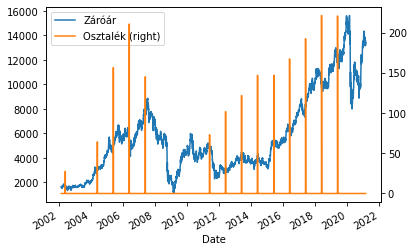

In [8]:
# Részvényárfolyam és osztalékfizetés
ax=otp_hist.Close.plot( label='Záróár', 
                       legend=True)
ax=otp_hist.Dividends.plot(secondary_y=True, 
                           label='Osztalék', 
                           legend=True)

## Hozam számolás

Hozam kiszámolható az egymást követő adatok hányadosaként vagy log hányadosaként is. A _log return_ ami a folyamatos kamatozásnak felel meg statisztikai tulajdonságait fogom részletesen vizsgálni.

In [9]:
# egyszerű hozam
otp_hist['simple_return'] = otp_hist.Close.pct_change()
# loghozam
otp_hist['log_return'] = np.log(otp_hist.Close/otp_hist.Close.shift(1))

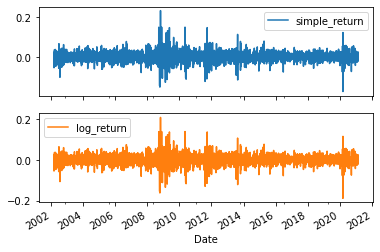

In [10]:
ax=otp_hist[['simple_return', 'log_return']].plot(subplots=True, layout=(2,1))

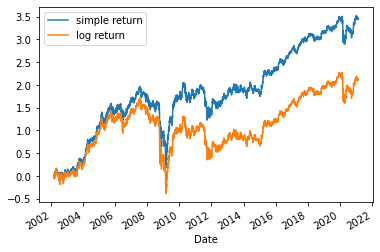

In [11]:
otp_hist.simple_return.cumsum().plot(label='simple return', legend='True')
ax=otp_hist.log_return.cumsum().plot(label='log return', legend='True')

In [12]:
a = otp_hist.Close[0] * np.exp(len(otp_hist)*otp_hist.log_return.mean())
b = otp_hist.Close[-1]

print(f'Az adatsor utolsó záró értéke az adatsor első értéke és a log hozam szorzataként: \
{a:.2f} vs az adatsor tényleges utolsó hozamértéke:{b:.2f}')

Az adatsor utolsó záró értéke az adatsor első értéke és a log hozam szorzataként: 13225.71 vs az adatsor tényleges utolsó hozamértéke:13220.00


## Hozam eloszlásának normalitásvizsgálata

A kérdés hogy a hozamot ha véletlenszerűnek tekintjük akkor az eloszlása normális eloszlást követ-e?

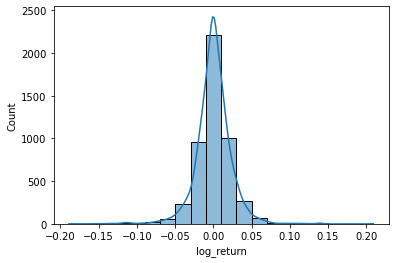

In [13]:
ax=sns.histplot(otp_hist.log_return,stat='count', kde=True, bins=20)

Ránézésre normális eloszlásnak tűnik, de ezt számokkal kell alátámasztani. Az eloszlás diagrammból mindenesetre kitűnik a 'long tail' mindkét oldalon.

### Kolmogorov-Smirnov teszt 
Azt vizsgálja hogy az eloszlás (illetve annak görbéje) mennyire hasonlít a normális eloszlás haranggörbéjéhez.

In [28]:
from scipy import stats
stats.kstest(otp_hist.log_return.dropna(), cdf='norm')

KstestResult(statistic=0.46706472513531716, pvalue=0.0)

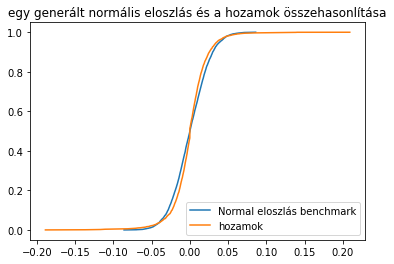

In [52]:
# készítek egy véletlenszerűen generált normális eloszlású sort
mu= otp_hist.log_return.dropna().mean()
sigma = otp_hist.log_return.dropna().std()
s = np.random.normal(mu, sigma, len(otp_hist.log_return.dropna()))
hmax = otp_hist.log_return.dropna().max()
hmin = otp_hist.log_return.dropna().min()

# összevetem a részvény hozam görbéjével
plt.figure()
plt.plot(np.sort(s), np.linspace(0, 1, len(s), endpoint=False))
plt.plot(np.sort(otp_hist.log_return.dropna()), 
         np.linspace(0, 1, len(otp_hist.log_return.dropna()), endpoint=False))
plt.legend('top right')
plt.legend(['Normal eloszlás benchmark', 'hozamok']) 
title='egy generált normális eloszlás és a hozamok összehasonlítása'
ax=plt.title(title)

### Paraméterpróba
Normális eloszlás ferdesége és csúcsossága egyaránt 0: ha akár a ferdeség, akár a csúcsosság szignifikánsan különbözik 0-tól akkor az eloszlás is szignifikánsan különbözik a normális eloszlástól. Ez egy alaki jellegű tesztelés

In [54]:
data = otp_hist.log_return.dropna()
print("Átlag     : ", np.mean(data))
print("Variancia : ", np.var(data))
print("Szórás    : ", np.std(data))
print("Ferdeség  : ", stats.skew(data))
print("Csúcsosság: ", stats.kurtosis(data))

Átlag     :  0.0004317573349483737
Variancia :  0.000550243785846451
Szórás    :  0.02345727575500725
Ferdeség  :  -0.25376997855082944
Csúcsosság:  7.647641836284583


A csúcsosság tekintetében a normális eloszlás nem teljesül. Az ilyen leptokurtikus hozameloszlások jellemzőek részvényekre. POrtfolioépítésnél ezt is figyelembe kell venni.

## A részvény adatsor leíró statisztikái

In [55]:
print(otp_hist.describe(percentiles=[.5]).T.round(2))

                count        mean         std      min        50%          max
Open           4876.0     5697.60     3238.73  1069.88    4898.33     15580.00
High           4876.0     5763.69     3266.73  1215.77    4962.47     15850.00
Low            4876.0     5626.13     3211.43   998.56    4828.35     15520.00
Close          4876.0     5696.13     3240.39  1098.25    4894.66     15630.00
Volume         4876.0  1279272.75  1391236.79     0.00  848372.50  26698424.00
Dividends      4876.0        0.41        8.23     0.00       0.00       221.35
Stock Splits   4876.0        0.00        0.00     0.00       0.00         0.00
simple_return  4875.0        0.00        0.02    -0.17       0.00         0.23
log_return     4875.0        0.00        0.02    -0.19       0.00         0.21


**Összefoglalás**: Az OTP  elmult 19 évének részvényárfolyamából számolt learó statisztikákat számolta(tta)m ki.

# Villamosenergia day ahead árak és fogyasztás kapcsolatának vizsgálata
Ebben a részben a HUPX Day ahead árak és a magyar villamosenergia rendszer fogyasztási görbéjét vizsgálom, egy tetszőleges napra vonatkozólag. A DAM árak T-1 napi aukció során alakultak ki. 

## Adatgyűjtés

Adatok letöltése az ENTSOE transparency platformról. Hupx jelöli a DAM árak tábláját, load pedig a terhelési adatokat.

In [17]:
country_code = 'HU'
start = pd.Timestamp('202102150000', tz='Europe/Brussels')
end = pd.Timestamp('202102152345', tz='Europe/Brussels')

hupx = client.query_day_ahead_prices(country_code, start=start,end=end)
load=client.query_load(country_code, start=start,end=end)

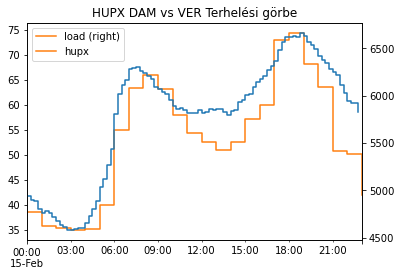

In [18]:
load.plot(secondary_y=True, drawstyle='steps-post', label='load', legend=True)
a = hupx.plot(drawstyle='steps-post', label='hupx', legend=True, 
              title =f'HUPX DAM vs VER Terhelési görbe')

Egy gyors regplot, hogy egyáltalán van e értelme vizsgálódnom:

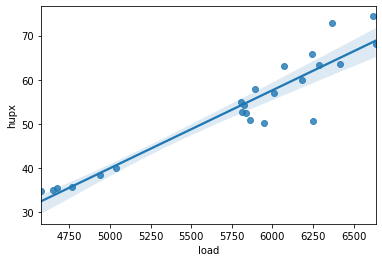

In [19]:
df = pd.DataFrame()
df['load'] = load
df['hupx'] = hupx
df.dropna(inplace=True)
ax = sns.regplot(x="load", y="hupx", data=df)

## Kétváltozós lineáris regressziós modell (kézi számolással)

X tengelyen a terhelési görbe ami az okozó tényező Y tengelyen a hupx DA árak.

$Y = \beta_0 + \beta_1X$

## Legkisebb négyzetek módszere
Munkatábla; az idősor tengelyre nincs szükség.

In [20]:
#X = load; Y= hupx
df['XiYi'] = df.load*df.hupx
df['Xi2'] = df.load*df.load
df.dropna()
df.head(3)

,load,hupx,XiYi,Xi2
2021-02-15 00:00:00+01:00,4942.0,38.53,190415.26,24423364.0
2021-02-15 01:00:00+01:00,4764.0,35.70,170074.80,22695696.0
2021-02-15 02:00:00+01:00,4676.0,35.42,165623.92,21864976.0


## Normálegyenletek megoldása determináns módszerrel

In [21]:
sumY = df.hupx.sum()
sumX2 = df['Xi2'].sum()
sumX = df.load.sum()
sumXY = df.XiYi.sum()
n = len(df)
b0= (sumY*sumX2-(sumX*sumXY))/(n*sumX2-(sumX*sumX))
b1 = (n*sumXY-sumY*sumX)/(n*sumX2-(sumX*sumX))
display(Latex(f'$\\beta_0:${b0:4f} $\\beta_1:${b1:4f}'))

<IPython.core.display.Latex object>

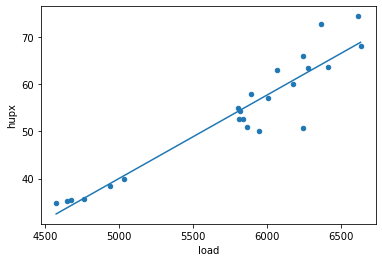

In [22]:
df.plot.scatter(x='load', y='hupx')
x_values = np.linspace(df.load.min(),df.load.max(),2)
y_linreg_values = b0+b1*x_values
ax=plt.plot(x_values,y_linreg_values)

In [23]:
print(f'A regressziófüggvény:Y = {b0:.2f} + {b1:.4f} X')
print(f'A villamosenergia fogyasztás 100 MWh-val való \
növekedése átlagosan {b1*100:.4f} EUR/MWh-val növelte \
a HUPX DA árait a vizsgált időszakban.')

A regressziófüggvény:Y = -48.28 + 0.0177 X
A villamosenergia fogyasztás 100 MWh-val való növekedése átlagosan 1.7656 EUR/MWh-val növelte a HUPX DA árait a vizsgált időszakban.


## Rugalmassági együttható: E(Y, X=5500)

In [24]:
X = 5500
E = b1 * X/(b0+b1*X)
print(f'Ha {X} MWh lett volna a fogyasztás és az 1%-kal nő, akkor az ár {E:.3f} EUR-ral nőne.')

Ha 5500 MWh lett volna a fogyasztás és az 1%-kal nő, akkor az ár 1.989 EUR-ral nőne.


## Lineáris korreláció szorossága

In [25]:
# covariance önmagában nem tul értelmes
df[['hupx', 'load']].cov()

,hupx,load
hupx,150.264585,7582.869012
load,7582.869012,429489.885375


In [26]:
# correlation normalizálja a covariance-t -1..+1 közé
df[['hupx', 'load']].corr()

,hupx,load
hupx,1.000000,0.943906
load,0.943906,1.000000


In [27]:
# ellenőrzés a scipy. stats-ból
import string
meredekség, tengelymetszet, r, pvalue, stderr = stats.linregress(df.load, df.hupx)

egyenlet = 'y = {:.2f}+{:.4f}x'.format(tengelymetszet,meredekség )
r = {'egyenlet': egyenlet,
    'r': f'{r:.4f}',
    'p': f'{pvalue:.4f}',
    'stderr': f'{stderr:.4f}'}

report = string.Template("""
HUPX DAM ár és VER fogyasztási adatok közötti kapcsolatvizsgálat
Ellenőrzése scipy.stats-szal
=================================================
Regressziós egyenlet : $egyenlet
Korreláció (r)       : $r
p érték              : $p
standard hiba        : $stderr
""")
print(report.substitute(r))



HUPX DAM ár és VER fogyasztási adatok közötti kapcsolatvizsgálat
Ellenőrzése scipy.stats-szal
Regressziós egyenlet : y = -48.28+0.0177x
Korreláció (r)       : 0.9439
p érték              : 0.0000
standard hiba        : 0.0013



Korreláció csak annyit jelent hogy együtt mozognak, nem azt hogy ok-okozati kapcsolat is van köztük. Hogy a HUPX DAM ár ami T-1 napi aukció nyomán születik meg az aukcióra beadott mennyiségek és árak kereslet kínálati összevetéséből és a T napi fogyasztási görbe amit előző napon a piaci szereplők menetrendeznek, forecastolnak, arra már korábban határidős és más ügyletekkel mennyiségeket lekötnek együtt mozog így teljesen el is fogadható. 
A 94% feletti pozitív  korreláció nagyon erősnek számít.

# A BÉT néhány részvényének korrelációs mátrixa

*Probléma*: Itt találomra kiválasztottam 10 BÉTen forgó részvényt és a 2020-as adataik alapján a köztük 3-5 leginkább ellentétesen mozgókat (uncorrelated assets)  fogom felhasználni a következő fejezetben a portfólió finomításához.

In [59]:
assets = "4IG.BD BIF.BD ALTEO.BD ANY.BD RABA.BD AKKO.BD DELTA.BD OTP.BD MOL.BD OPUS.BD"
data = yf.download(assets, start="2020-01-01", end="2020-12-31")
data['Adj Close'].iloc[:, :7].head(3)

[*********************100%***********************]  10 of 10 completed


,4IG.BD,AKKO.BD,ALTEO.BD,ANY.BD,BIF.BD,DELTA.BD,MOL.BD
Date,,,,,,,
2020-01-02,678.775269,440.0,850.0,1296.597534,298.934845,127.0,2960.0
2020-01-03,636.351807,438.0,882.0,1296.597534,299.902283,126.0,2950.0
2020-01-06,652.742676,424.0,892.0,1287.336060,300.869720,123.0,2882.0


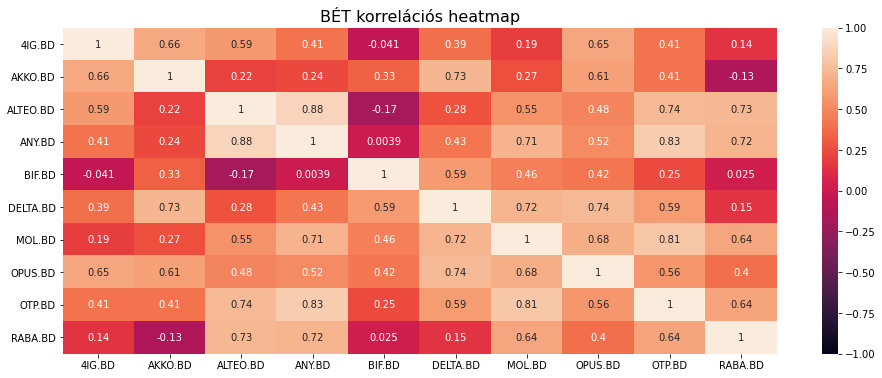

In [29]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(data['Adj Close'].corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('BÉT korrelációs heatmap', fontdict={'fontsize':16});

## TOP 5 legmagasabb korrelációs pár

In [30]:
def get_redundant_pairs(df):
    pairs_to_drop = set() # set-ben nem lehet ismétlődés
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5, asc=False):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=asc)
    return au_corr[0:n]

print("Top 5 legnagyobb absolut együttmozgó pár")
print(get_top_abs_correlations(data['Adj Close'],5, False))
print('\n')
print("Top 5 legkevésbé együttmozgó pár")
print(get_top_abs_correlations(data['Adj Close'],5, True))

Top 5 legnagyobb absolut együttmozgó pár
ALTEO.BD  ANY.BD     0.880234
ANY.BD    OTP.BD     0.833441
MOL.BD    OTP.BD     0.805529
ALTEO.BD  OTP.BD     0.740502
DELTA.BD  OPUS.BD    0.735441
dtype: float64


Top 5 legkevésbé együttmozgó pár
ANY.BD   BIF.BD     0.003949
BIF.BD   RABA.BD    0.024963
4IG.BD   BIF.BD     0.040921
AKKO.BD  RABA.BD    0.133068
4IG.BD   RABA.BD    0.143210
dtype: float64


Ezzel megvannak azok az eszközök amelyeket portfólióépítéshez használhatok.  A legkevésbé együttmozgó instrumentumokkal lehet a portfóliót kiegyensúlyozni. Az eszközök kiválasztására pedig a kiigazított záróárakra alkalmazott korrelációs számítást használtam.

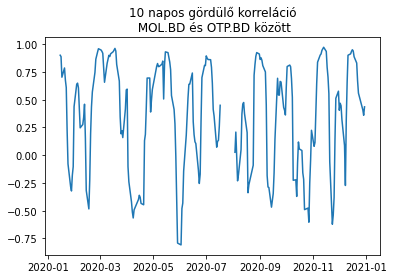

In [31]:
# Gördülő korreláció: a korreláció időbeli változását mutatja 2 részvény között
n=10
r1 = 'MOL.BD'
r2 = 'OTP.BD'
rolling_correlation = data['Close']['MOL.BD'].rolling(n).corr(data['Close']['OTP.BD'])
plt.title(f'{n} napos gördülő korreláció\n {r1} és {r2} között')
ax=plt.plot(rolling_correlation)

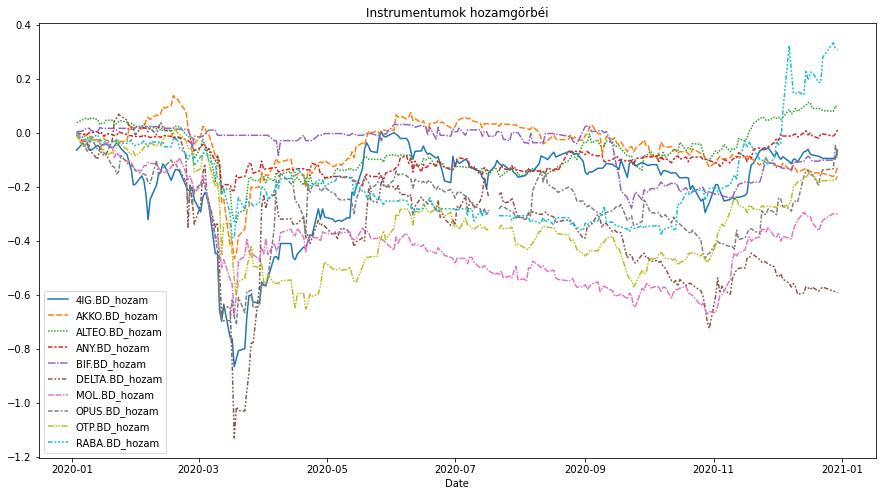

In [32]:
data2 = pd.DataFrame()
for c in data['Adj Close'].columns:
    colname = c+'_hozam'
    data2[colname] = np.log(data['Adj Close'][c]/data['Adj Close'][c].shift(1))

plt.figure(figsize=(15,8))
plt.title('Instrumentumok hozamgörbéi')
ax=sns.lineplot(data=data2.cumsum())

# Idősorelemzés VER 2020-2021Q1
A magyar villamosenergia rendszer terhelési görbéjét fogom elemezni 2020.01.01-től 2021.02.15ig.
Az adatokat az Entsoe transparency platform API-ról töltöm le.

## AdatLetöltés

In [33]:
# Terhelési görbe (tg) adatok lekérdezése
start = pd.Timestamp('202001010000', tz='Europe/Brussels')
end   = pd.Timestamp('202102162345', tz='Europe/Brussels')
tg    = client.query_load('HU', start=start,end=end)

## Adattábla egyszerű vizsgálata

In [34]:
# Adatsor első pár sora
print(tg.head())

# Intervallum explicit beadása.. erre most nem lesz szükség
# tg = tg.asfreq(freq='15min')

# Van e null érték az adatsorban?
print(f'Null érték van-e? {tg.isnull().any()}')

2020-01-01 00:00:00+01:00    4374.0
2020-01-01 00:15:00+01:00    4324.0
2020-01-01 00:30:00+01:00    4284.0
2020-01-01 00:45:00+01:00    4220.0
2020-01-01 01:00:00+01:00    4173.0
dtype: float64
Null érték van-e? False


In [35]:
# Adatsor leíró statisztikái
print(tg.describe().round(2))

count    39632.00
mean      4957.02
std        803.66
min       2998.00
25%       4363.00
50%       4925.00
75%       5551.25
max       6827.00
dtype: float64


Az első lényeges megfigyelést itt tehetjük: 2020 január 1 től a magyar VER terhelésének minimum és maximum értékei meghatározhatóak. A fenti leíró statisztika megmutatja az adattípust is (float) azaz nem kell konvertálni és statisztikai elemzésre az adat így alkalmas. <BR>
Az időpecsét UTC időzona formátumban van, ami az óraátállítások kezelése miatt szükséges, főleg ha az ENTSOE adatbázisából mondjuk Romániával akarnám összehasonlítani az adatokat.

## Vizualizálás

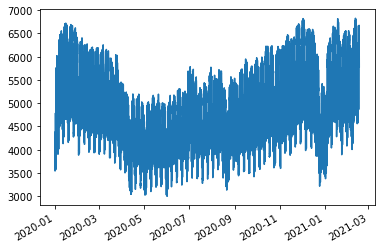

In [36]:
ax=tg.plot()

Az egész időszaknyi  negyedórás adat kirajzolása egy sűrű grafikont eredményez. Az látszik belőle hogy idősor, ciklikusság van benne, vannak szakaszai amelyekben trend is megfigyelhető. Kiugró értékeket itt nem lehet megállapítani. Első ránézésre csak annyit tudok mondani róla hogy elemzésre alkalmas lesz.

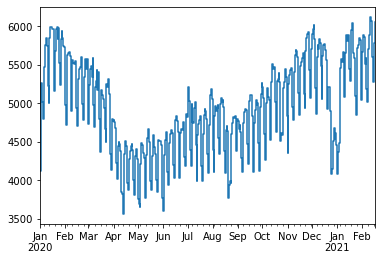

In [37]:
# Adatsor aggregálása napi átlagok szintjére. 
ax = tg.resample('d').mean().plot(drawstyle='steps-post')

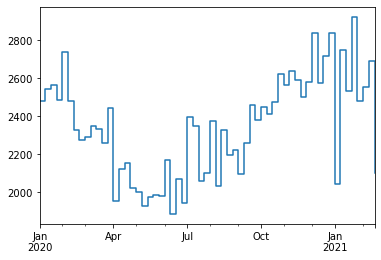

In [38]:
range = (tg.resample('w').max()-tg.resample('w').min()).plot(drawstyle='steps-post')

Heti agregált adat szélessége. Juniusban a legalacsonyabb a  heti minimum és maximum közti különbség, a téli hónapokban pedig a legmagasabb.

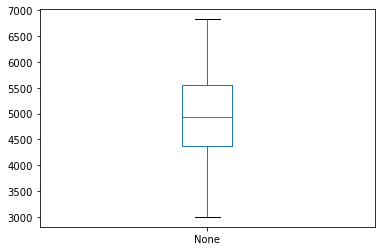

In [39]:
ax=tg.plot(kind='box')

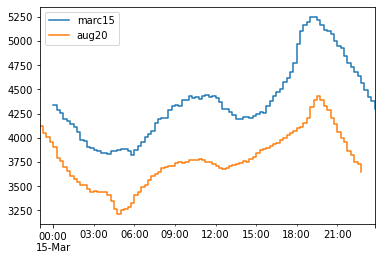

In [40]:
# két adott nap, március 15-e és augusztus 20 megjelenítése 
# naptípusonkénti elemzés majd lejjebb
ax=tg.loc['2020-03-15 00:00':'2020-03-15 23:45'].plot(drawstyle='steps-post', label='marc15', legend=True)
ax=tg.loc['2020-08-20 00:00':'2020-08-20 23:45'].shift(-158, freq='D').plot(drawstyle='steps-post', label='aug20', legend=True)

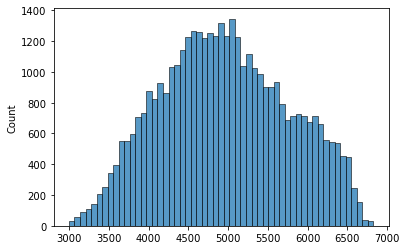

In [41]:
ax= sns.histplot(tg)

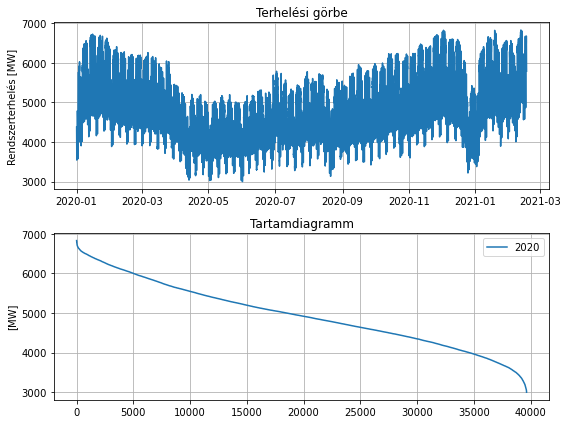

In [42]:
# Tartamgörbe
fig = plt.figure(figsize=(8,6))
ax = fig.add_axes([0.1, 0.1, 0.6, 0.75])

plt.subplot(2,1,1)
plt.plot(tg)
plt.ylabel('Rendszerterhelés [MW]')
plt.grid(True)
plt.title('Terhelési görbe')

plt.subplot(2,1,2)
plt.plot(tg.sort_values(ascending=False).to_list(), label='2020')
plt.ylabel('[MW]')
plt.title('Tartamdiagramm')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [43]:
print('Max Load: \t{}, {} MW'.format(tg.idxmax(), tg.max()))
print('Min Load: \t{}, {} MW'.format(tg.idxmin(), tg.min()))
peak = tg.between_time('08:00', '20:00')
print('Max Peak Load: \t{}, {} MW'.format(peak.idxmax(), peak.max()))
print('Min Peak Load: \t{}, {} MW'.format(peak.idxmin(), peak.min()))

Max Load: 	2021-02-11 17:45:00+01:00, 6827.0 MW
Min Load: 	2020-06-01 05:30:00+02:00, 2998.0 MW
Max Peak Load: 	2021-02-11 17:45:00+01:00, 6827.0 MW
Min Peak Load: 	2020-04-12 13:45:00+02:00, 3361.0 MW


A maximális _rendszerterhelés_ már 2021-ben volt. A minimális rendszerterhelés pedig nem a  2020 áprilisi első pandemiahullám idején.

## Stacionaritás vizsgálata

Egy idősor akkor tekinthető stacionáriusnak ha az idősor maradék tagjának 
- várható értéke, 
- varianciája, 
- autokovarianciája

nem függ az időtől. Ilyen esetben a folyamat lefutása az időben stabil, nincs trendhatás. Az ilyen idősoroknak jó a rövid távú előrejelezhetősége.

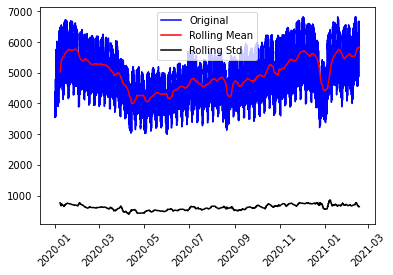

In [44]:
rolmean = tg.rolling(window = 96*7, center = False).mean()
rolstd = tg.rolling(window = 96*7, center = False).std()
orig = plt.plot(tg,color = 'blue',label = 'Original')
mean = plt.plot(rolmean,color = 'red',label = 'Rolling Mean')
std = plt.plot(rolstd,color = 'black',label = 'Rolling Std')
plt.legend(loc = 'best')
plt.xticks(rotation = 45)
plt.show(block = False)
plt.close()

In [45]:
dftest = adfuller(tg)
print(f'Test Statistic: {dftest[0]:.4f}')
print(f'p value: {dftest[1]:.8f}')
for key, value in dftest[4].items():
    print(f'Critical value {key}: {value:.4f}')
    
if dftest[0] < dftest[4]["5%"]:
    print ("Ho elutasítható: Az idősor stacioner")
else:
    print ("Ho nem elutasítható - Az idősor NEM stacioner")

Test Statistic: -13.6729
p value: 0.00000000
Critical value 1%: -3.4305
Critical value 5%: -2.8616
Critical value 10%: -2.5668
Ho elutasítható: Az idősor stacioner


ADF teszt esetén a Ho hipotézis az hogy az adatsor NEM stacionárius. Ha a Test statisztika < Critical value akkor elutasíthatjuk a Ho-t. Jelen esetben ez igaz tehát az adatsor stacionárius. Ami, ha belegondolok végülis valós, hiszen egy gazdaság terhelési görbéje csak akkor "trendelne" ha vagy hatalmas gazdasági növekedés lenne ami már egy ilyen 12-13 hónapos időszakban is érzékelhető lenne, vagy - és erre volt esély - olyan mély válság alakulna ki  hogy tartosan és folyamatosan csökkenne a villamos energia igény iránti igény. De a fenti időszakban a géppark, erőműpark nem változott jelentősen és a pandemia hatása is csak az év március-április hónapjaira koncentrálódott, legalábbis villamosenergia fogyasztás szempontjából.

## Idősor szétbontása

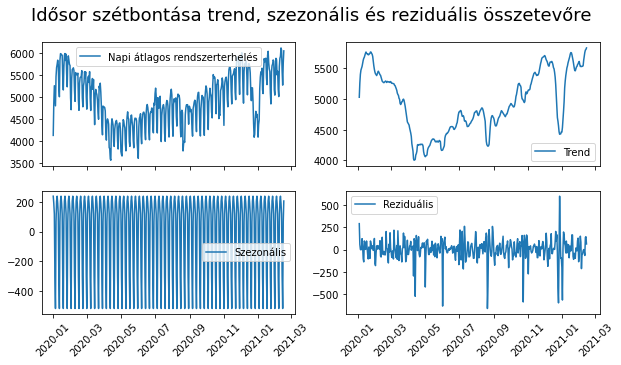

In [46]:
decomposition = seasonal_decompose(tg.resample('d').mean())

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (10, 5), sharex = True)

ax1.plot(tg.resample('d').mean(), label = 'Napi átlagos rendszerterhelés')
ax1.legend(loc = 'best')
ax1.tick_params(axis = 'x', rotation = 45)

ax2.plot(decomposition.trend, label = 'Trend')
ax2.legend(loc = 'best')
ax2.tick_params(axis = 'x', rotation = 45)

ax3.plot(decomposition.seasonal,label = 'Szezonális')
ax3.legend(loc = 'best')
ax3.tick_params(axis = 'x', rotation = 45)

ax4.plot(decomposition.resid, label = 'Reziduális')
ax4.legend(loc = 'best')
ax4.tick_params(axis = 'x', rotation = 45)

# Show graph
plt.suptitle('Idősor szétbontása trend, szezonális és reziduális összetevőre',
            fontsize = 18)
plt.show() 

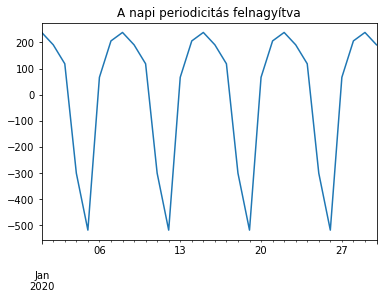

In [47]:
t='A napi periodicitás felnagyítva'
ax=decomposition.seasonal.loc['2020-01-01':'2020-01-30'].plot(title=t)

In [48]:
# szezonalitás átlaga

A rendszerterhelést szétbontottam az idősorban rejlő alapirányzatra, periodikus ingadozásra és egy véletlenszerű komponensre. Ez utóbbinál a kiugró értékek további vizsgálatot igényelnek.

## ARIMA model

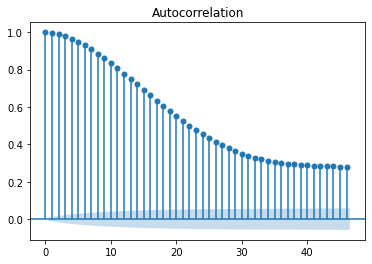

In [49]:
acf =sm.graphics.tsa.plot_acf(tg)

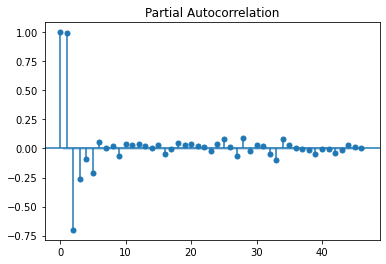

In [50]:
pacf=sm.graphics.tsa.plot_pacf(tg)

In [51]:
from statsmodels.tsa.arima.model import ARIMA
arima = ARIMA(tg.resample('h').mean(), order=(2,1,1)).fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 9911
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -61555.313
Date:                Sat, 20 Feb 2021   AIC                         123118.625
Time:                        10:07:28   BIC                         123147.431
Sample:                    01-01-2020   HQIC                        123128.380
                         - 02-16-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6901      0.005    336.416      0.000       1.680       1.700
ar.L2         -0.8017      0.004   -206.199      0.000      -0.809      -0.794
ma.L1         -0.9510      0.004   -242.762      0.000      -0.959      -0.943
sigma2      1.455e+04    144.591    100.658      0.000    1.43e+04    1.48e+04
===================================================================================
Ljung-Box (L1) (Q):                 112.66   Jarque-Bera (JB):              4064.59
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
import scipy.stats as scs

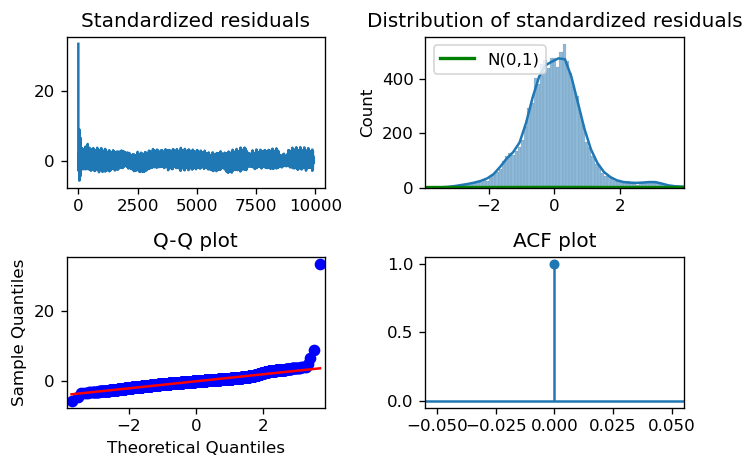

In [53]:
resids = arima.resid
n_lags = 40

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.dpi = 120
r = resids
resids = (r - np.nanmean(r)) / np.nanstd(r)
resids_nonmissing = resids[~(np.isnan(resids))]

# residuals over time
sns.lineplot(x=np.arange(len(resids)), y=resids, ax=ax1)
ax1.set_title('Standardized residuals')

# distribution of residuals
x_lim = (-1.96 * 2, 1.96 * 2)
r_range = np.linspace(x_lim[0], x_lim[1])
norm_pdf = scs.norm.pdf(r_range)
sns.histplot(resids_nonmissing, kde=True, ax=ax2)
ax2.plot(r_range, norm_pdf, 'g', lw=2, label='N(0,1)')
ax2.set_title('Distribution of standardized residuals')
ax2.set_xlim(x_lim)
ax2.legend()

# Q-Q plot
qq = sm.qqplot(resids_nonmissing, line='s', ax=ax3)
ax3.set_title('Q-Q plot')

# ACF plot
sm.graphics.tsa.plot_pacf(resids, ax=ax4, lags=n_lags, alpha=0.05)
x=ax4.set_title('ACF plot')
plt.tight_layout()

In [54]:
arima.resid.values

array([ 4.30050000e+03, -3.43147145e+02, -9.41935053e+01, ...,
       -7.13180740e+01, -3.26297056e+00, -4.04459148e+01])

In [65]:
xresid = arima.resid.values[~np.isnan(arima.resid.values)]
ljung_box_results = sm.stats.acorr_ljungbox(xresid, lags=[20], return_df=True)
ljung_box_results.round(4)

,lb_stat,lb_pvalue
20,604.0584,0.0


In [66]:
def run_arima_model(ts, p, d, q):    
    model = ARIMA(ts, order=(p, d, q))  
    results_ = model.fit()  
    
    len_results = len(results_.fittedvalues)
    ts_modified = ts[-len_results:]

    # calculate residual sum of squares (RSS)
    rss = sum((results_.fittedvalues - ts_modified)**2)
    # calculate root mean square error (RMSE)
    rmse = np.sqrt(rss / len(ts))

    plt.plot(ts)
    plt.plot(results_.fittedvalues, color = 'red')
    plt.title('For ARIMA model (%i, %i, %i) for ts , RSS: %.4f, RMSE: %.4f' %(p, d, q,  rss, rmse))
    plt.show()
    plt.close()

    return results_

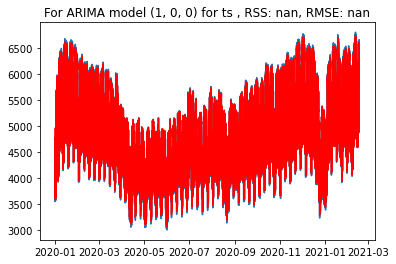

C:\Users\janos\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


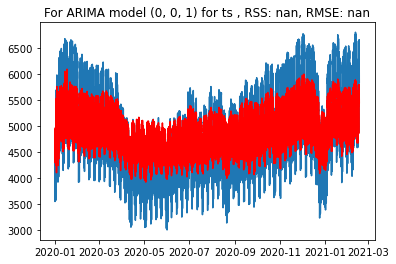

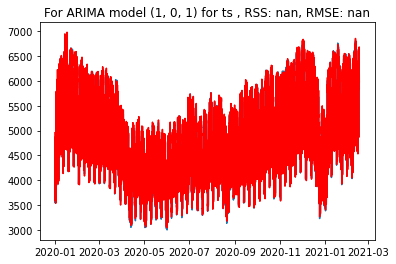

In [67]:
ts = tg.resample('h').mean()

model_AR = run_arima_model(ts,p = 1,d = 0,q = 0)
model_MA = run_arima_model(ts,p = 0,d = 0,q = 1)
model_ARMA = run_arima_model(ts,p = 1,d = 0,q = 1)

TODO: Forecasting 

# Beta, CAPM, Optimális portfólió
Ebben a fejezetben kiszámítom a beruházáselemzés órán elhangzott példák alapján az OTP és ZWACK ( esetleg a fenti 10 mintarészvény) hozamait, betáját, generálok rá valahogy egy tojásgörbét, még nemtom hogyan de illesztek a tojásra egy SML-t.

.. már ha tudom

## CAPM

In [68]:
RISKY_ASSET = 'OTP.BD'
MARKET_BENCHMARK = '^BUX'
START_DATE = '2021-01-01'
END_DATE = '2021-02-20'

In [186]:
df = yf.download([RISKY_ASSET, MARKET_BENCHMARK],
                 start=START_DATE,
                 end=END_DATE,
                 adjusted=True,
                 progress=False)

In [187]:
X = df['Adj Close'].rename(columns={RISKY_ASSET: 'asset', MARKET_BENCHMARK: 'market'}) \
.resample('D').last().pct_change().dropna()

In [188]:
covariance = X.cov().iloc[0,1]

benchmark_variance = X.market.var()
beta = covariance / benchmark_variance

In [189]:
beta

0.5312850735982912

In [190]:
y = X.pop('asset')
X = sm.add_constant(X)
capm_model = sm.OLS(y, X).fit()
print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  asset   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     9.713
Date:                Sat, 20 Feb 2021   Prob (F-statistic):            0.00322
Time:                        02:00:56   Log-Likelihood:                 144.60
No. Observations:                  46   AIC:                            -285.2
Df Residuals:                      44   BIC:                            -281.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.002     -0.395      0.6

Ezek szerint ha a BUX-ot vesszük a piacnak és az OTP-BUX Beta-jat nézzük. Akkor a vizsgált időszakra a beta 0.5313 azaz az OTP fele olyan volatilis mint a piac egésze.

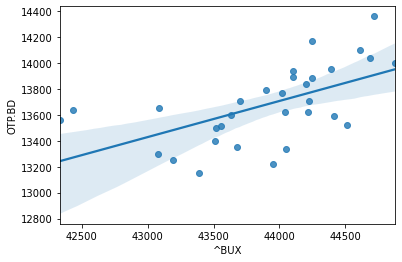

In [196]:
ax = sns.regplot(y=RISKY_ASSET, x=MARKET_BENCHMARK, data=df['Adj Close'])

## Eszköz allokáció

In [50]:
import numpy as np
import scipy.optimize as sco

In [51]:
N_PORTFOLIOS = 1000 
RISKY_ASSETS = ['OTP.BD', 'ZWACK.BD', 'MOL.BD', '4IG.BD']
START_DATE = '2020-01-01'
END_DATE = '2020-12-31'
prices_df = yf.download(RISKY_ASSETS, start=START_DATE,end=END_DATE, adjusted=True)

[*********************100%***********************]  4 of 4 completed


In [52]:
n_assets = len(RISKY_ASSETS)
N_DAYS = len(prices_df)

In [53]:
# Éves SIMPLE hozam számolás
# TODO: log return-ra is meg kellene
returns_df = prices_df['Adj Close'].pct_change().dropna()
avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS

In [54]:
# Random portfolio súlyokkal
np.random.seed(42)
weights = np.random.random(size=(N_PORTFOLIOS, n_assets))
weights /= np.sum(weights, axis=1)[:, np.newaxis]

In [58]:
# Portfolió mérőszámok súlyokkal
# Hozam
pHozam = np.dot(weights, avg_returns)

#Volatilitás
pVola = []
for i in range(0, len(weights)):
    pVola.append(np.sqrt(np.dot(weights[i].T,np.dot(cov_mat, weights[i]))))
pVola = np.array(pVola)

# Sharpe ratio
pSharpe = pHozam / pVola

In [43]:
# dataframesítés
portf_results_df = pd.DataFrame({'returns'     : pHozam,
                                 'volatility'  : pVola,
                                 'sharpe_ratio': pSharpe})

In [59]:
# Határvonal megkeresése

N_POINTS = 100
portf_vol_ef = []
indices_to_skip = []
portf_rtns_ef = np.linspace(portf_results_df.returns.min(),
                            portf_results_df.returns.max(),
                            N_POINTS)

portf_rtns_ef = np.round(portf_rtns_ef, 2)
portf_rtns = np.round(portf_rtns, 2)

for point_index in range(N_POINTS):
    if portf_rtns_ef[point_index] not in portf_rtns:
        indices_to_skip.append(point_index)
        continue
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index])
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))

portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

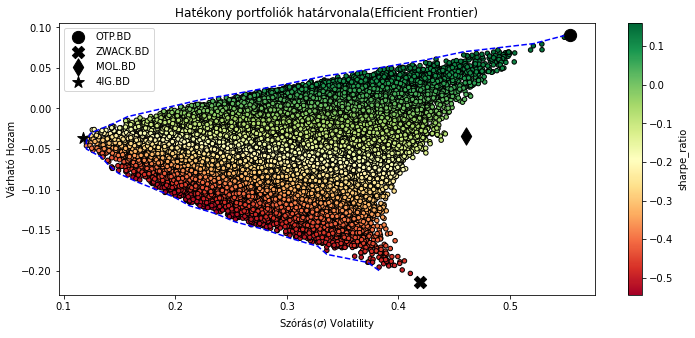

In [64]:
MARKS = ['o', 'X', 'd', '*']

fig, ax = plt.subplots(figsize=(12,5))
# egy sima pontdiagram, csak kap mellé egy hőmérőt ami a sharpe-t mutatja
# és a pontok  is ez alapján vannak szinezve
portf_results_df.plot(kind='scatter',
                      x='volatility',
                      y='returns', 
                      c='sharpe_ratio',
                      cmap='RdYlGn', 
                      edgecolors='black',
                      ax=ax)

ax.set(xlabel='Szórás($\sigma$) Volatility',
       ylabel='Várható Hozam',
       title='Hatékony portfoliók határvonala(Efficient Frontier)')

# ez a határvonal
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')

# és itt meg lerakom a kiválasztott részvények jeleit
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]),
               y=avg_returns[asset_index],
               marker=MARKS[asset_index],
               s=150,
               color='black',
               label=RISKY_ASSETS[asset_index])
ax = ax.legend()

# Forrásjegyzék

